In [1]:
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import cv2

class Yolo_detector(object):
    
    def __init__(self,config,weights,classes_file):
        with open(classes_file, 'r') as f:
            self.classes = [line.strip() for line in f.readlines()]
        self.COLORS = np.random.uniform(0, 255, size=(len(self.classes), 3))
        self.net = cv2.dnn.readNet(weights, config)
        
    def get_output_layers(self):
        layer_names = self.net.getLayerNames()
        output_layers = [layer_names[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]
        return output_layers

    def draw_prediction(self,img, class_id, confidence, x, y, x_plus_w, y_plus_h):
        label = str(self.classes[class_id])+" "+str(round(confidence,1))
        color = self.COLORS[class_id]
        cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
        cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        
    def detect(self,image):
        Width = image.shape[1]
        Height = image.shape[0]
        scale = 0.00392
        blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

        self.net.setInput(blob)

        outs = self.net.forward(self.get_output_layers())
        return outs
    
    def detect_and_draw(self,image):
        return self.draw(image,self.detect(image))
    
    
    def draw(self,image,outs):
        class_ids = []
        confidences = []
        boxes = []
        conf_threshold = 0.5
        nms_threshold = 0.4

        Width = image.shape[1]
        Height = image.shape[0]
        scale = 0.00392

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * Width)
                    center_y = int(detection[1] * Height)
                    w = int(detection[2] * Width)
                    h = int(detection[3] * Height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])

        indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
        for i in indices:
            i = i[0]
            box = boxes[i]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            self.draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

        return(image)


In [3]:
config='E:/yolo/yolov3.cfg'
weights='E:/yolo/yolov3.weights'
classes_file='E:/yolo/yolov3.txt'

detector=Yolo_detector(config,weights,classes_file)

done in 1.15  sec


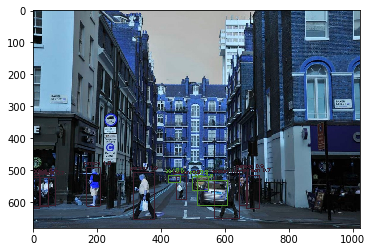

In [4]:
image=cv2.imread('E:/yolo/street.jpg')
import time

start=time.time()
im=detector.detect_and_draw(image)
print("done in", round(time.time()-start,2)," sec")
plt.imshow(im)

In [ ]:
#realtime detecion from webcam streaming

video_capture = cv2.VideoCapture(0)

#to use IP cameras
#video_capture=cv2.VideoCapture('http://192.168.8.108:4747/video')

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    

    if ret:
    # Display the resulting frame
        frame=detector.detect_and_draw(frame)
        cv2.imshow('Video', frame)
    else:
        print(".",end="")

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()